This will add attention at the middle, maybe feature importance?
Not done yet

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, matthews_corrcoef, accuracy_score, balanced_accuracy_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import RobustScaler
import matplotlib.pyplot as plt
import random

In [2]:
# Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
tf.keras.utils.set_random_seed(SEED)
tf.config.experimental.enable_op_determinism()

In [3]:
def prepare_sequence_data(df):
    """Convert sequences to integer encoding with validation"""
    alphabet = 'ARNDCQEGHILKMFPSTWYV-'
    char_to_int = dict((c, i) for i, c in enumerate(alphabet))
    
    sequences = df['sequence'].values
    encodings = []
    
    for i, seq in enumerate(sequences):
        try:
            if pd.isna(seq):
                print(f"Warning: Found null sequence at index {i}")
                continue
            if not isinstance(seq, str):
                print(f"Warning: Non-string sequence at index {i}: {type(seq)}")
                continue
            integer_encoded = [char_to_int[char] for char in seq]
            encodings.append(integer_encoded)
        except Exception as e:
            print(f"Error processing sequence at index {i}: {str(e)}")
            print(f"Sequence: {seq}")
            continue
    
    encodings = np.array(encodings, dtype=np.float32)
    print(f"Sequence data shape: {encodings.shape}")
    return encodings

In [4]:
def prepare_structure_data(df):
    """Enhanced feature preparation with validation"""
    def normalize_angles(angle_array):
        angle_rad = np.pi * angle_array / 180.0
        return np.stack([np.sin(angle_rad), np.cos(angle_rad)], axis=-1)
    
    features_list = []
    
    # Process angles
    angles = ['phi', 'psi', 'omega', 'tau']
    for angle in angles:
        try:
            angle_arrays = np.array([np.array(eval(x)) for x in df[angle]])
            angle_features = normalize_angles(angle_arrays)
            features_list.append(angle_features)
        except Exception as e:
            print(f"Error processing {angle}: {str(e)}")
            raise
    
    # Process SASA
    try:
        sasa_arrays = np.array([np.array(eval(x)) for x in df['sasa']])
        scaler = RobustScaler()
        sasa_flat = sasa_arrays.reshape(-1, 1)
        sasa_scaled = scaler.fit_transform(sasa_flat).reshape(sasa_arrays.shape)
        features_list.append(sasa_scaled[..., np.newaxis])
    except Exception as e:
        print(f"Error processing SASA: {str(e)}")
        raise
    
    # Process secondary structure
    try:
        ss_arrays = np.array([list(seq) for seq in df['ss']])
        ss_encoded = np.zeros((len(ss_arrays), ss_arrays.shape[1], 3))
        ss_map = {'H': 0, 'E': 1, 'L': 2}
        for i in range(len(ss_arrays)):
            for j in range(len(ss_arrays[i])):
                ss_encoded[i, j, ss_map[ss_arrays[i, j]]] = 1
        features_list.append(ss_encoded)
    except Exception as e:
        print(f"Error processing secondary structure: {str(e)}")
        raise
    
    features = np.concatenate(features_list, axis=-1)
    features = features.astype(np.float32)
    print(f"Structure data shape: {features.shape}")
    return features

In [5]:
def create_combined_model(seq_length=33, struct_features=12, struct_window=0):
    """Create model with both sequence and structure tracks, including track weights and attention"""
    # Calculate window size
    struct_positions = 1 + (2 * struct_window)
    middle_pos = seq_length // 2
    
    # Sequence track
    seq_input = tf.keras.layers.Input(shape=(seq_length,), name='sequence_input')
    x_seq = tf.keras.layers.Embedding(21, 21, input_length=seq_length)(seq_input)
    x_seq = tf.keras.layers.Reshape((seq_length, 21, 1))(x_seq)
    x_seq = tf.keras.layers.Conv2D(32, kernel_size=(17, 3), activation='relu', padding='valid')(x_seq)
    x_seq = tf.keras.layers.Dropout(0.2)(x_seq)
    x_seq = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x_seq)
    x_seq = tf.keras.layers.Flatten()(x_seq)
    x_seq = tf.keras.layers.Dense(32, activation='relu', name='seq_features')(x_seq)
    x_seq = tf.keras.layers.Dropout(0.2)(x_seq)
    
    # Structure track with adaptive size
    struct_input = tf.keras.layers.Input(shape=(seq_length, struct_features), name='structure_input')
    
    if struct_window == 0:
        x_struct = tf.keras.layers.Lambda(
            lambda x: x[:, middle_pos:middle_pos+1, :]
        )(struct_input)
    else:
        x_struct = tf.keras.layers.Lambda(
            lambda x: x[:, middle_pos-struct_window:middle_pos+struct_window+1, :]
        )(struct_input)
    
    total_struct_features = struct_positions * struct_features
    struct_dense_size = min(total_struct_features * 2, 128)
    
    x_struct = tf.keras.layers.Conv1D(32, 3, padding='same', activation='relu')(x_struct)
    x_struct = tf.keras.layers.BatchNormalization()(x_struct)
    x_struct = tf.keras.layers.Dropout(0.2)(x_struct)
    x_struct = tf.keras.layers.Flatten()(x_struct)
    x_struct = tf.keras.layers.Dense(struct_dense_size, activation='relu', name='struct_features')(x_struct)
    x_struct = tf.keras.layers.Dropout(0.2)(x_struct)
    
    # Initial combination for track weights
    combined = tf.keras.layers.Concatenate(name='combined_features')([x_seq, x_struct])
    
    # Track weights
    weight_layer = tf.keras.layers.Dense(2, activation='softmax', name='track_weights')
    track_weights = weight_layer(combined)
    
    weighted_seq = tf.keras.layers.Multiply(name='weighted_seq')([
        x_seq,
        tf.keras.layers.Lambda(lambda x: x[:, 0:1])(track_weights)
    ])
    
    weighted_struct = tf.keras.layers.Multiply(name='weighted_struct')([
        x_struct,
        tf.keras.layers.Lambda(lambda x: x[:, 1:2])(track_weights)
    ])
    
    weighted_combined = tf.keras.layers.Concatenate(name='weighted_combined')([weighted_seq, weighted_struct])
    
    # Add attention after weighting
    attention = tf.keras.layers.Dense(64, activation='tanh', name='attention_dense1')(weighted_combined)
    attention = tf.keras.layers.Dense(1, activation='sigmoid', name='attention_weights')(attention)
    attended_features = tf.keras.layers.Multiply(name='attention_applied')([weighted_combined, attention])
    
    # Final layers
    x = tf.keras.layers.Dense(32, activation='relu')(attended_features)
    x = tf.keras.layers.Dropout(0.2)(x)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    
    model = tf.keras.Model(inputs=[seq_input, struct_input], outputs=outputs)
    
    def get_track_weights():
        w = model.get_layer('track_weights').get_weights()
        if len(w) > 0:
            weights = w[0]
            bias = w[1] if len(w) > 1 else 0
            exp_weights = np.exp(np.mean(weights, axis=0) + bias)
            normalized = exp_weights / np.sum(exp_weights)
            return {
                'sequence': float(normalized[0]),
                'structure': float(normalized[1])
            }
        return {'sequence': 0.5, 'structure': 0.5}
    
    def get_attention_weights():
        try:
            dense1_weights = model.get_layer('attention_dense1').get_weights()[0]
            dense2_weights = model.get_layer('attention_weights').get_weights()[0]
            
            combined_weights = np.abs(np.dot(dense1_weights, dense2_weights)).flatten()
            normalized_weights = combined_weights / np.sum(combined_weights)
            
            seq_weights = normalized_weights[:32]
            struct_weights = normalized_weights[32:32+struct_dense_size]
            
            feature_names = [
                'phi_sin', 'phi_cos',
                'psi_sin', 'psi_cos',
                'omega_sin', 'omega_cos',
                'tau_sin', 'tau_cos',
                'sasa',
                'ss_H', 'ss_E', 'ss_L'
            ]
            
            struct_dict = {}
            for pos in range(-struct_window, struct_window + 1):
                pos_start = (pos + struct_window) * len(feature_names)
                pos_end = pos_start + len(feature_names)
                if pos_end <= len(struct_weights):
                    pos_weights = struct_weights[pos_start:pos_end]
                    for feat_name, weight in zip(feature_names, pos_weights):
                        key = f"pos{pos}_{feat_name}"
                        struct_dict[key] = weight
            
            return {
                'sequence_importance': float(np.mean(seq_weights)),
                'structure_importance': float(np.mean(struct_weights)),
                'track_weights': get_track_weights(),
                'feature_weights': {
                    'sequence': list(seq_weights),
                    'structure': struct_dict
                }
            }
        except Exception as e:
            print(f"Error getting attention weights: {str(e)}")
            return None
    
    model.get_attention_weights = get_attention_weights
    model.get_track_weights = get_track_weights
    
    return model

In [6]:
def plot_attention_weights(attention_info, fold=None):
    """Plot attention weights analysis"""
    if attention_info:
        plt.figure(figsize=(15, 10))
        
        # Plot track weights
        plt.subplot(2, 2, 1)
        track_weights = attention_info['track_weights']
        plt.bar(['Sequence', 'Structure'], 
                [track_weights['sequence'], track_weights['structure']])
        plt.title('Track Weights')
        plt.ylabel('Weight')
        
        # Plot sequence feature importance
        plt.subplot(2, 2, 2)
        seq_weights = attention_info['feature_weights']['sequence']
        plt.bar(range(len(seq_weights)), seq_weights)
        plt.title('Sequence Feature Importance')
        plt.xlabel('Feature Index')
        plt.ylabel('Importance')
        
        # Plot structure feature importance
        plt.subplot(2, 1, 2)
        struct_features = attention_info['feature_weights']['structure']
        plt.bar(range(len(struct_features)), list(struct_features.values()))
        plt.xticks(range(len(struct_features)), list(struct_features.keys()), rotation=90)
        plt.title('Structure Feature Importance by Position')
        plt.ylabel('Importance')
        
        plt.tight_layout()
        # if fold is not None:
        #     plt.savefig(f'attention_weights_fold_{fold}.png')
        plt.show()

In [ ]:
def train_and_evaluate(struct_window=0):
    """Training function with improved monitoring and validation"""
    # Load data
    print("Loading data...")
    train_df = pd.read_csv("../data/processed_data_train_after.csv")
    test_df = pd.read_csv("../data/processed_data_test_after.csv")
    
    # Prepare data
    X_train_seq = prepare_sequence_data(train_df)
    X_test_seq = prepare_sequence_data(test_df)
    X_train_struct = prepare_structure_data(train_df)
    X_test_struct = prepare_structure_data(test_df)
    
    y_train = train_df['label'].values.astype(np.float32)
    y_test = test_df['label'].values.astype(np.float32)
    
    # Calculate class weights
    total_samples = len(y_train)
    pos_samples = np.sum(y_train == 1)
    neg_samples = np.sum(y_train == 0)
    
    class_weights = {
        0: total_samples / (2 * neg_samples),
        1: total_samples / (2 * pos_samples)
    }
    
    # Print class weights
    print(f"Class Weights: {class_weights}")
    
    # Callbacks
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True,
            mode='min'
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=5,
            min_lr=1e-6,
            mode='min',
            verbose=1
        )
    ]
    
    # Cross validation
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    metrics = {'acc': [], 'balanced_acc': [], 'mcc': [], 'sn': [], 'sp': []}
    test_predictions = []
    attention_history = []
    
    for fold, (train_idx, val_idx) in enumerate(kfold.split(X_train_seq), 1):
        print(f"\nFold {fold}/5")
        
        model = create_combined_model(
            seq_length=33,
            struct_features=X_train_struct.shape[2],
            struct_window=struct_window
        )
        
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )
        
        history = model.fit(
            [X_train_seq[train_idx], X_train_struct[train_idx]],
            y_train[train_idx],
            validation_data=(
                [X_train_seq[val_idx], X_train_struct[val_idx]],
                y_train[val_idx]
            ),
            batch_size=32,
            epochs=50,
            callbacks=callbacks,
            class_weight=class_weights,
            verbose=1
        )
        
        # Evaluate fold
        y_pred = model.predict([X_train_seq[val_idx], X_train_struct[val_idx]])
        y_pred_binary = (y_pred > 0.5).astype(int)
        
        # Calculate metrics
        cm = confusion_matrix(y_train[val_idx], y_pred_binary)
        metrics['acc'].append(accuracy_score(y_train[val_idx], y_pred_binary))
        metrics['balanced_acc'].append(balanced_accuracy_score(y_train[val_idx], y_pred_binary))
        metrics['mcc'].append(matthews_corrcoef(y_train[val_idx], y_pred_binary))
        metrics['sn'].append(cm[1][1]/(cm[1][1]+cm[1][0]))
        metrics['sp'].append(cm[0][0]/(cm[0][0]+cm[0][1]))
        
        # Get and store attention weights
        attention_info = model.get_attention_weights()
        attention_history.append(attention_info)
        
        # Plot attention weights for this fold
        plot_attention_weights(attention_info, fold)
        
        print(f"\nFold {fold} Results:")
        for metric in metrics:
            print(f"{metric.upper()}: {metrics[metric][-1]:.4f}")
        
        # Print feature importance for this fold
        if attention_info:
            print("\nTrack Weights:")
            print(f"Sequence: {attention_info['track_weights']['sequence']:.4f}")
            print(f"Structure: {attention_info['track_weights']['structure']:.4f}")
        
        # Store test predictions
        test_pred = model.predict([X_test_seq, X_test_struct])
        test_predictions.append(test_pred)
        
        # Plot training curves
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title(f'Loss - Fold {fold}')
        plt.legend()
        
        plt.subplot(1, 2, 2)
        plt.plot(history.history['accuracy'], label='Training Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title(f'Accuracy - Fold {fold}')
        plt.legend()
        # plt.savefig(f'training_curves_fold_{fold}.png')
        plt.show()
    
    # Print final cross-validation results
    print("\nFinal Cross-validation Results:")
    for metric in metrics:
        mean_val = np.mean(metrics[metric])
        std_val = np.std(metrics[metric])
        print(f"{metric.upper()}: {mean_val:.4f} ± {std_val:.4f}")
    
    # Calculate average attention weights
    avg_track_weights = {
        'sequence': np.mean([info['track_weights']['sequence'] for info in attention_history]),
        'structure': np.mean([info['track_weights']['structure'] for info in attention_history])
    }
    
    print("\nAverage Track Weights Across Folds:")
    print(f"Sequence: {avg_track_weights['sequence']:.4f} ± "
          f"{np.std([info['track_weights']['sequence'] for info in attention_history]):.4f}")
    print(f"Structure: {avg_track_weights['structure']:.4f} ± "
          f"{np.std([info['track_weights']['structure'] for info in attention_history]):.4f}")
    
    # Calculate ensemble predictions
    test_pred_avg = np.mean(test_predictions, axis=0)
    test_pred_binary = (test_pred_avg > 0.5).astype(int)
    
    # Final test set evaluation
    final_cm = confusion_matrix(y_test, test_pred_binary)
    print("\nFinal Test Set Results:")
    print(f"Accuracy: {accuracy_score(y_test, test_pred_binary):.4f}")
    print(f"Balanced Accuracy: {balanced_accuracy_score(y_test, test_pred_binary):.4f}")
    print(f"MCC: {matthews_corrcoef(y_test, test_pred_binary):.4f}")
    print(f"Sensitivity: {final_cm[1][1]/(final_cm[1][1]+final_cm[1][0]):.4f}")
    print(f"Specificity: {final_cm[0][0]/(final_cm[0][0]+final_cm[0][1]):.4f}")
    
    return model, attention_history

Training model with window size: 0
This will consider 1 positions centered on the target residue
Loading data...
Sequence data shape: (8850, 33)
Sequence data shape: (2737, 33)
Structure data shape: (8850, 33, 12)
Structure data shape: (2737, 33, 12)

Fold 1/5


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
2024-12-03 20:15:23.225282: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-12-03 20:15:23.225302: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-12-03 20:15:23.225307: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-12-03 20:15:23.225322: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-03 20:15:23.225333: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/50


2024-12-03 20:15:24.060368: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


222/222 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - accuracy: 0.4912 - loss: 0.6950 - val_accuracy: 0.5282 - val_loss: 0.6916 - learning_rate: 5.0000e-04
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - accuracy: 0.5445 - loss: 0.6893 - val_accuracy: 0.6186 - val_loss: 0.6559 - learning_rate: 5.0000e-04
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - accuracy: 0.6415 - loss: 0.6373 - val_accuracy: 0.6915 - val_loss: 0.6028 - learning_rate: 5.0000e-04
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - accuracy: 0.6965 - loss: 0.5880 - val_accuracy: 0.7232 - val_loss: 0.5611 - learning_rate: 5.0000e-04
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - accuracy: 0.7318 - loss: 0.5480 - val_accuracy: 0.7328 - val_loss: 0.5417 - learning_rate: 5.0000e-04
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - accuracy: 0.7433 - loss: 0.5283 - val_accuracy: 0.7328 - val_loss: 0.5333 - learning_rate: 5.0000e-04
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - accuracy: 0.7

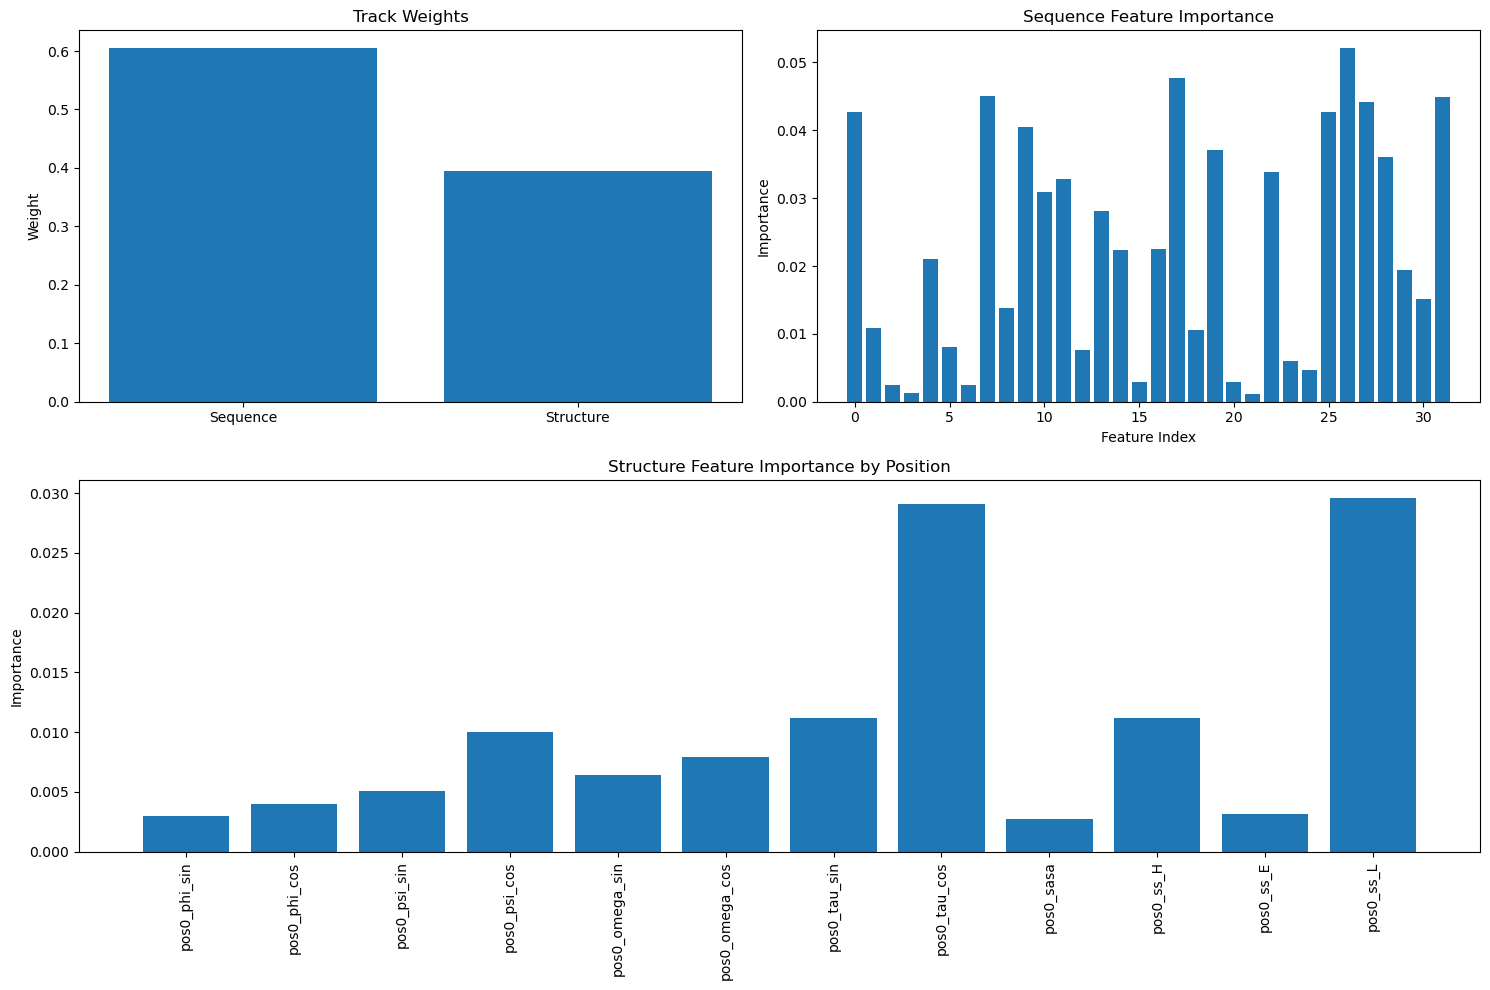


Fold 1 Results:
ACC: 0.7469
BALANCED_ACC: 0.7448
MCC: 0.4947
SN: 0.8105
SP: 0.6791

Track Weights:
Sequence: 0.6052
Structure: 0.3948
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


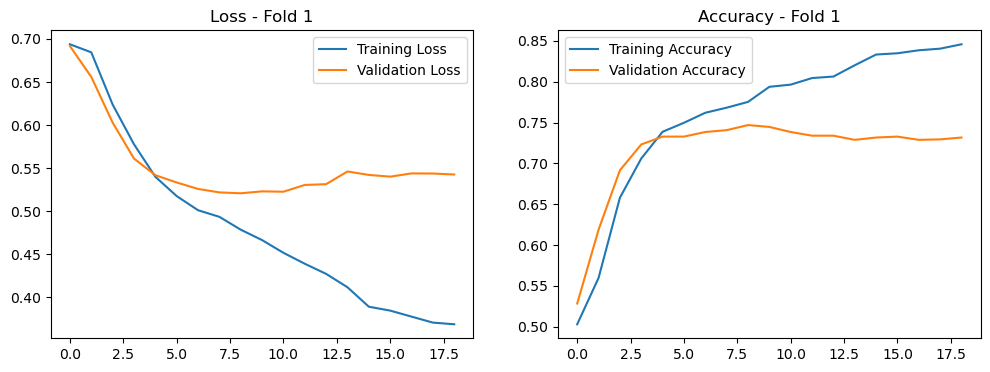


Fold 2/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - accuracy: 0.5126 - loss: 0.6935 - val_accuracy: 0.5542 - val_loss: 0.6905 - learning_rate: 5.0000e-04
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.5442 - loss: 0.6867 - val_accuracy: 0.6333 - val_loss: 0.6516 - learning_rate: 5.0000e-04
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.6302 - loss: 0.6500 - val_accuracy: 0.6768 - val_loss: 0.6099 - learning_rate: 5.0000e-04
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.6787 - loss: 0.6096 - val_accuracy: 0.7107 - val_loss: 0.5682 - learning_rate: 5.0000e-04
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.7137 - loss: 0.5717 - val_accuracy: 0.7384 - val_loss: 0.5493 - learning_rate: 5.0000e-04
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.7251 - loss: 0.5495 - val_accuracy: 0.7401 - val_loss: 0.5270 - learning_rate: 5.0000e-04
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - accuracy: 0.7

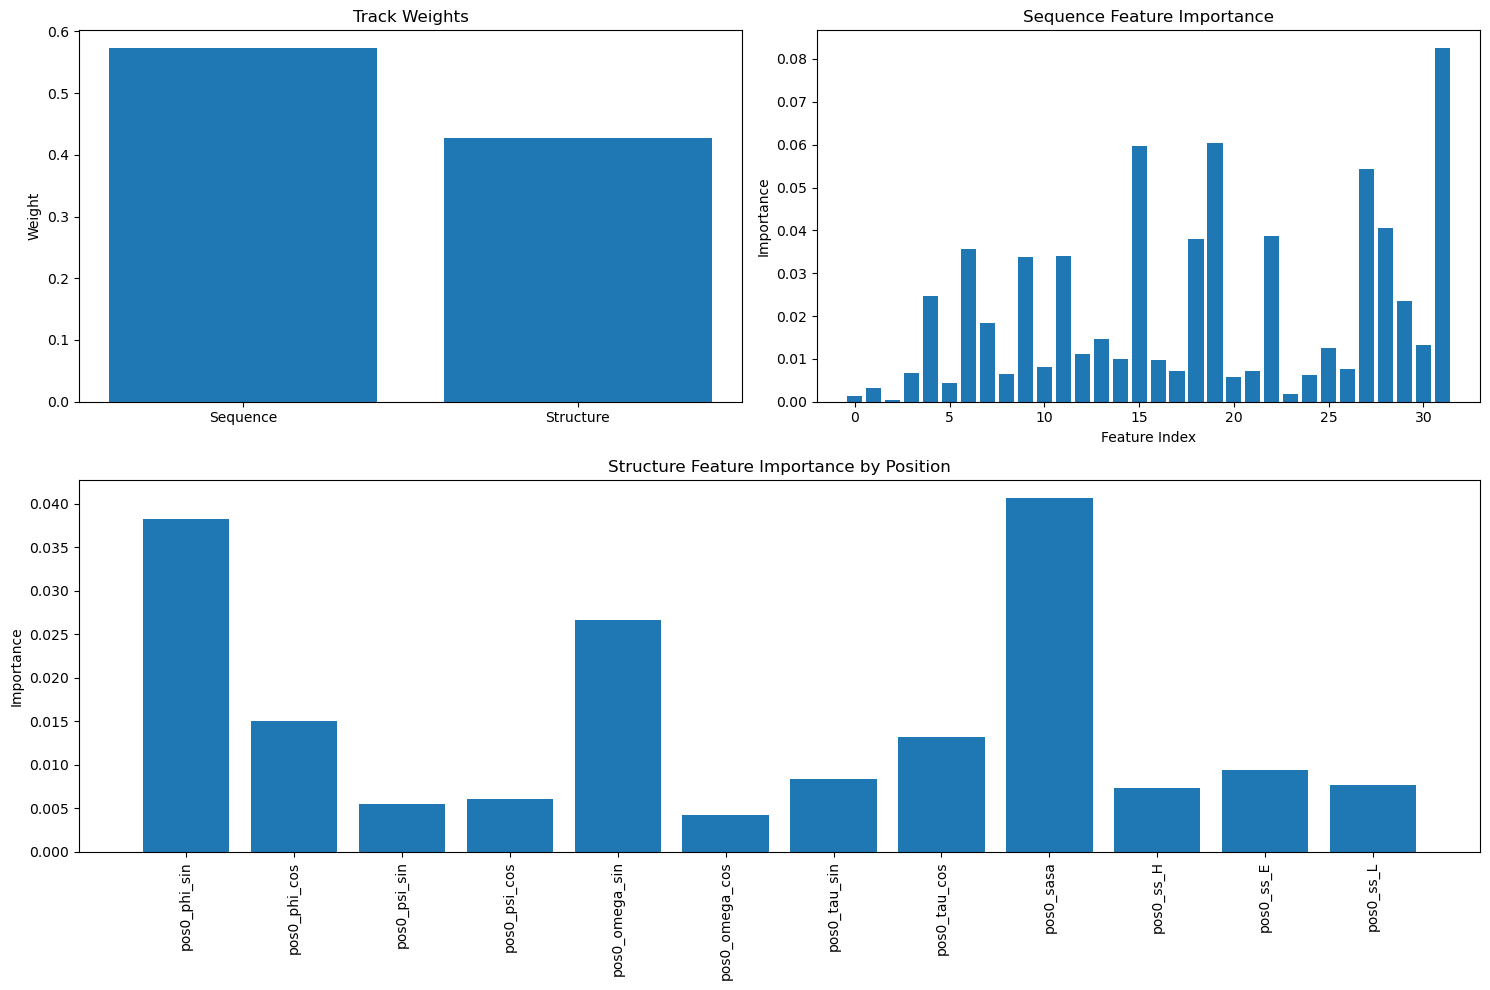


Fold 2 Results:
ACC: 0.7475
BALANCED_ACC: 0.7441
MCC: 0.4926
SN: 0.8024
SP: 0.6859

Track Weights:
Sequence: 0.5730
Structure: 0.4270
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


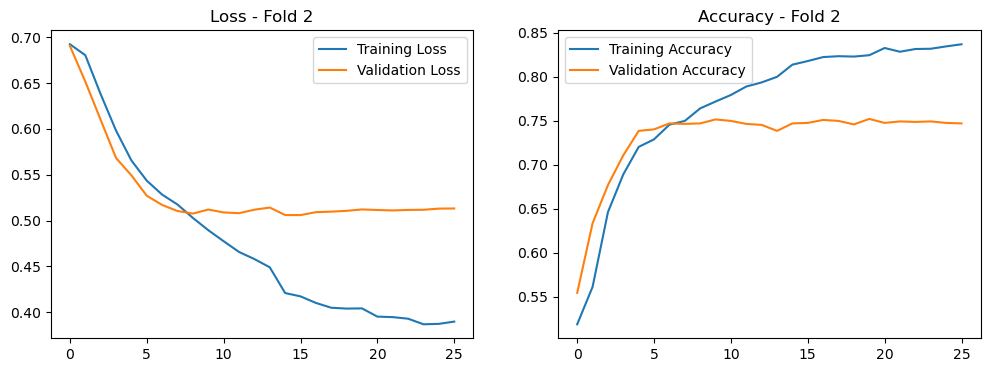


Fold 3/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - accuracy: 0.5077 - loss: 0.6946 - val_accuracy: 0.5277 - val_loss: 0.6921 - learning_rate: 5.0000e-04
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - accuracy: 0.5282 - loss: 0.6905 - val_accuracy: 0.6232 - val_loss: 0.6592 - learning_rate: 5.0000e-04
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - accuracy: 0.6278 - loss: 0.6444 - val_accuracy: 0.6514 - val_loss: 0.6216 - learning_rate: 5.0000e-04
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - accuracy: 0.6822 - loss: 0.6071 - val_accuracy: 0.6915 - val_loss: 0.5888 - learning_rate: 5.0000e-04
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - accuracy: 0.7030 - loss: 0.5648 - val_accuracy: 0.7254 - val_loss: 0.5542 - learning_rate: 5.0000e-04
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - accuracy: 0.7306 - loss: 0.5402 - val_accuracy: 0.7288 - val_loss: 0.5416 - learning_rate: 5.0000e-04
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - accuracy: 0.7

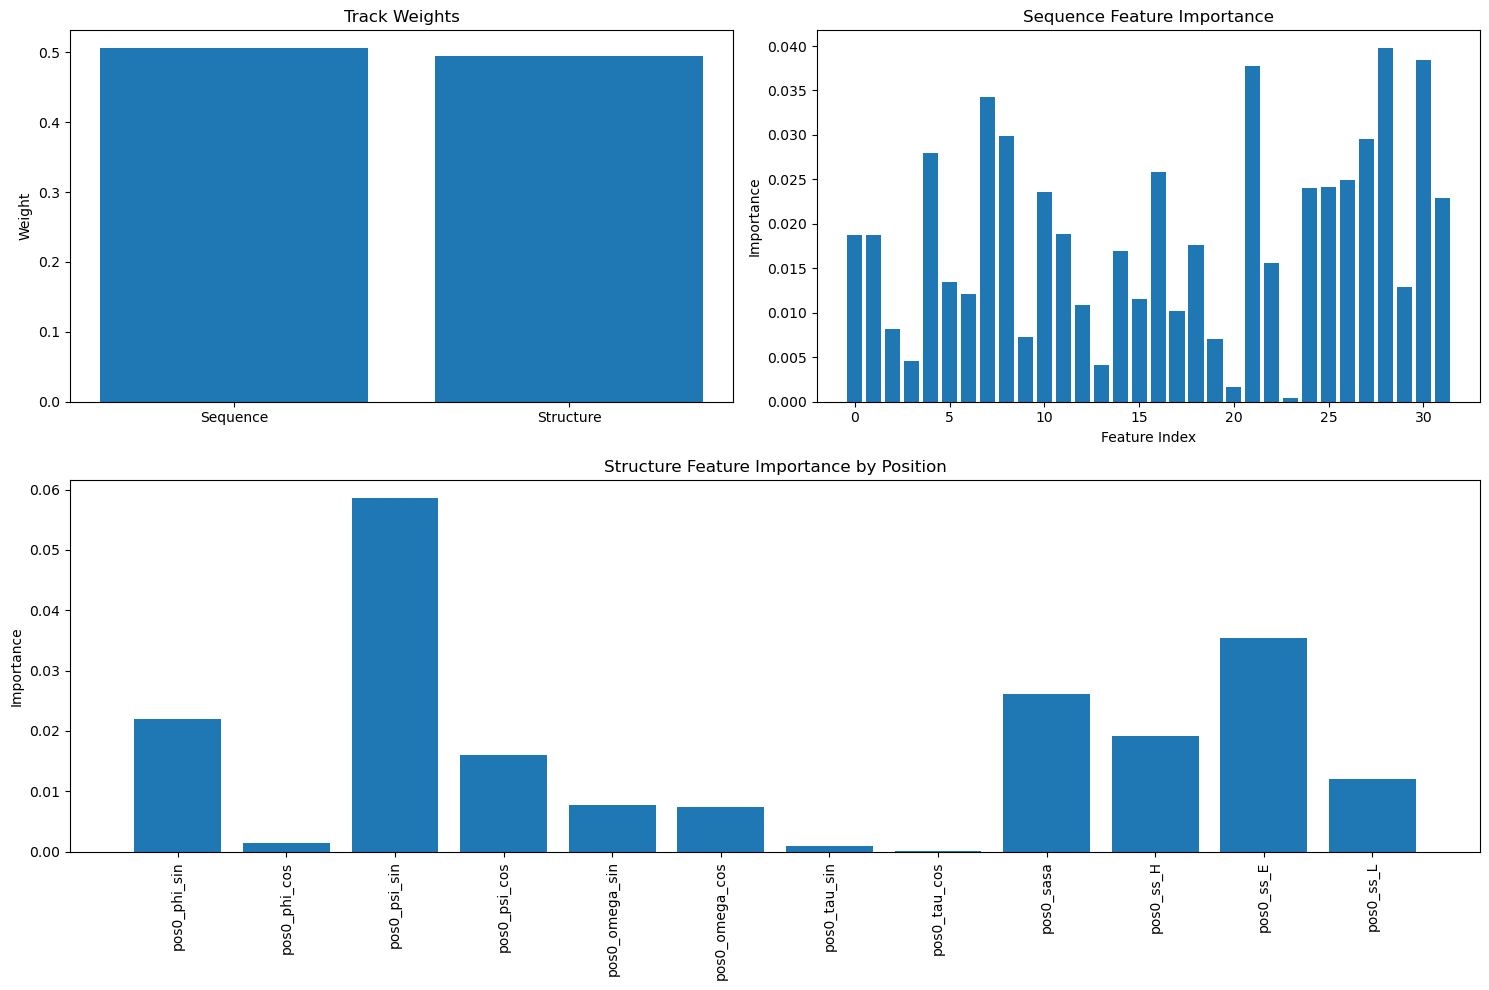


Fold 3 Results:
ACC: 0.5277
BALANCED_ACC: 0.5258
MCC: 0.0519
SN: 0.5860
SP: 0.4656

Track Weights:
Sequence: 0.5061
Structure: 0.4939
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


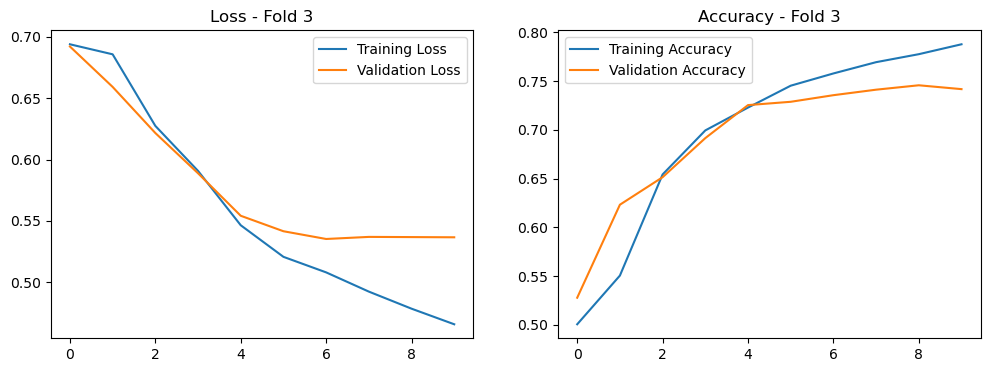


Fold 4/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - accuracy: 0.5177 - loss: 0.6949 - val_accuracy: 0.5203 - val_loss: 0.6925 - learning_rate: 5.0000e-04
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 36s 163ms/step - accuracy: 0.5174 - loss: 0.6927 - val_accuracy: 0.5362 - val_loss: 0.6912 - learning_rate: 5.0000e-04
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 19s 83ms/step - accuracy: 0.5278 - loss: 0.6896 - val_accuracy: 0.6040 - val_loss: 0.6611 - learning_rate: 5.0000e-04
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 15s 66ms/step - accuracy: 0.6508 - loss: 0.6298 - val_accuracy: 0.7164 - val_loss: 0.5677 - learning_rate: 5.0000e-04
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 14s 65ms/step - accuracy: 0.7156 - loss: 0.5601 - val_accuracy: 0.7345 - val_loss: 0.5464 - learning_rate: 5.0000e-04
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 15s 66ms/step - accuracy: 0.7355 - loss: 0.5357 - val_accuracy: 0.7384 - val_loss: 0.5385 - learning_rate: 5.0000e-04
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 15s 67ms/step - accura

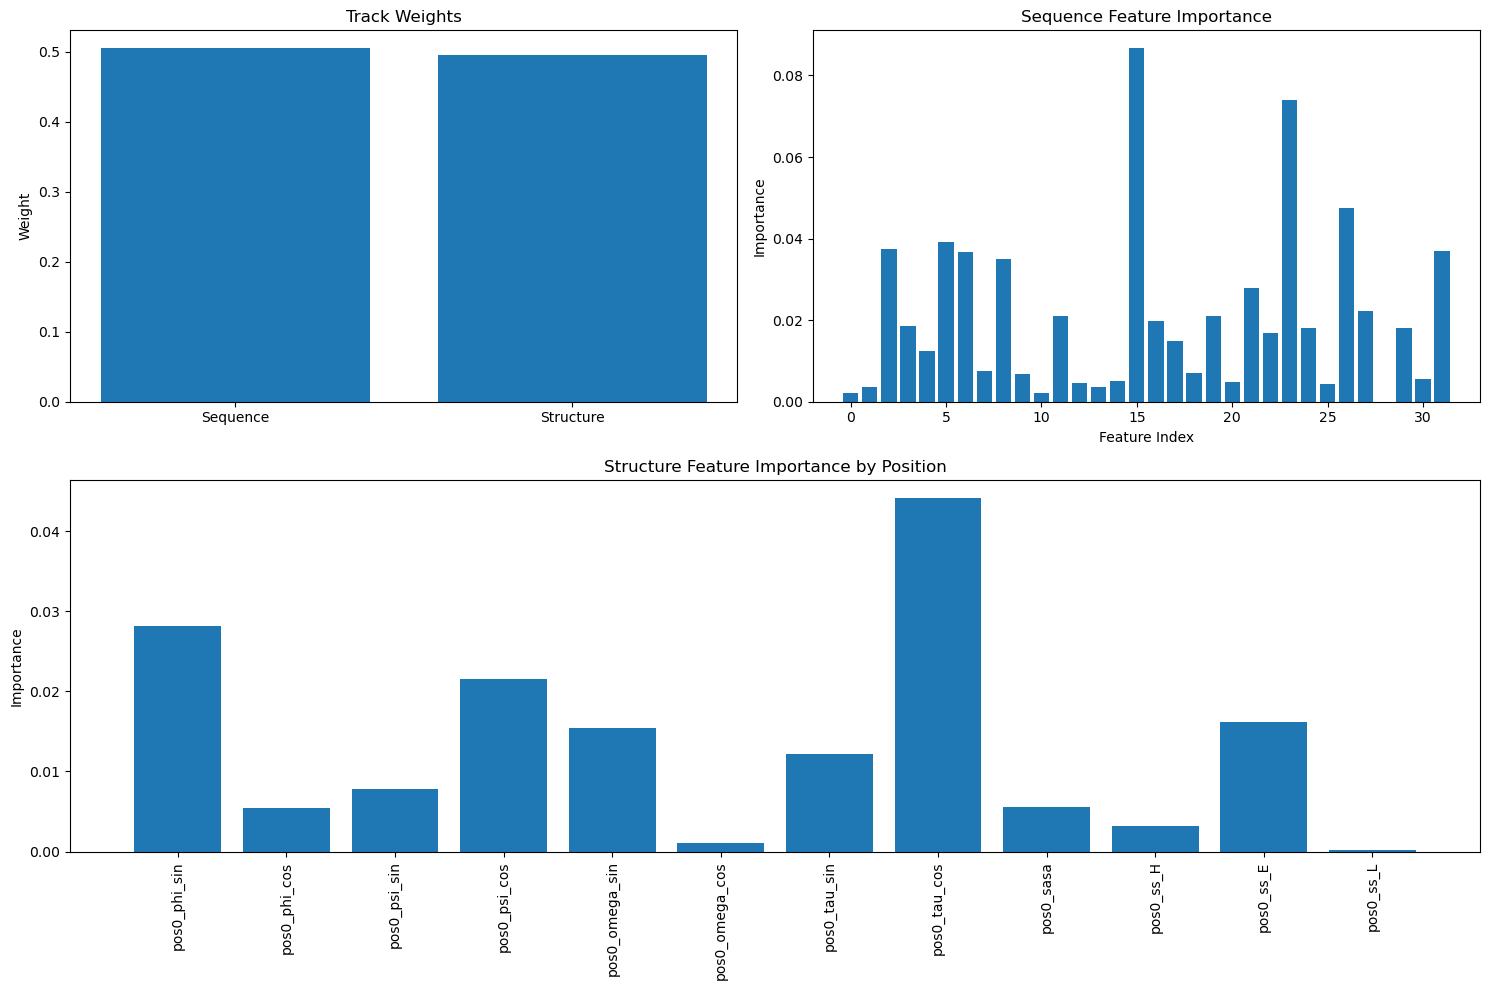


Fold 4 Results:
ACC: 0.5203
BALANCED_ACC: 0.5047
MCC: 0.0695
SN: 1.0000
SP: 0.0093

Track Weights:
Sequence: 0.5053
Structure: 0.4947
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


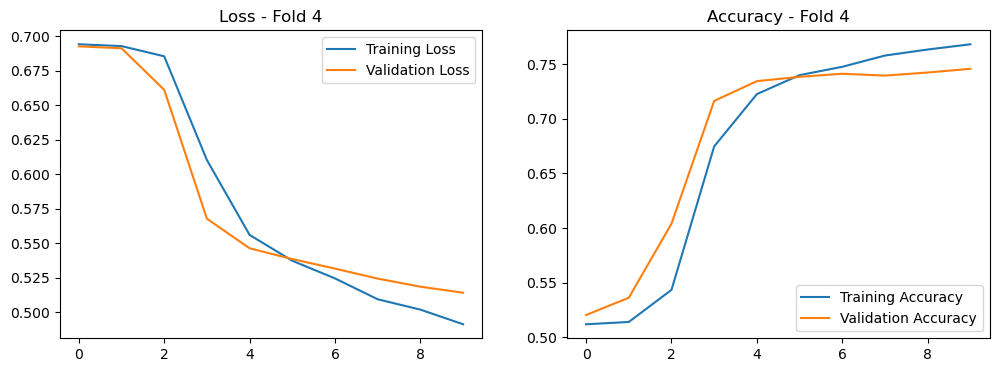


Fold 5/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 16s 56ms/step - accuracy: 0.5002 - loss: 0.6934 - val_accuracy: 0.5294 - val_loss: 0.6919 - learning_rate: 5.0000e-04
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - accuracy: 0.5707 - loss: 0.6831 - val_accuracy: 0.6395 - val_loss: 0.6312 - learning_rate: 5.0000e-04
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.6668 - loss: 0.6193 - val_accuracy: 0.6910 - val_loss: 0.5804 - learning_rate: 5.0000e-04
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.7118 - loss: 0.5718 - val_accuracy: 0.7209 - val_loss: 0.5472 - learning_rate: 5.0000e-04
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - accuracy: 0.7390 - loss: 0.5439 - val_accuracy: 0.7243 - val_loss: 0.5384 - learning_rate: 5.0000e-04
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - accuracy: 0.7434 - loss: 0.5269 - val_accuracy: 0.7333 - val_loss: 0.5334 - learning_rate: 5.0000e-04
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - accuracy: 0.7

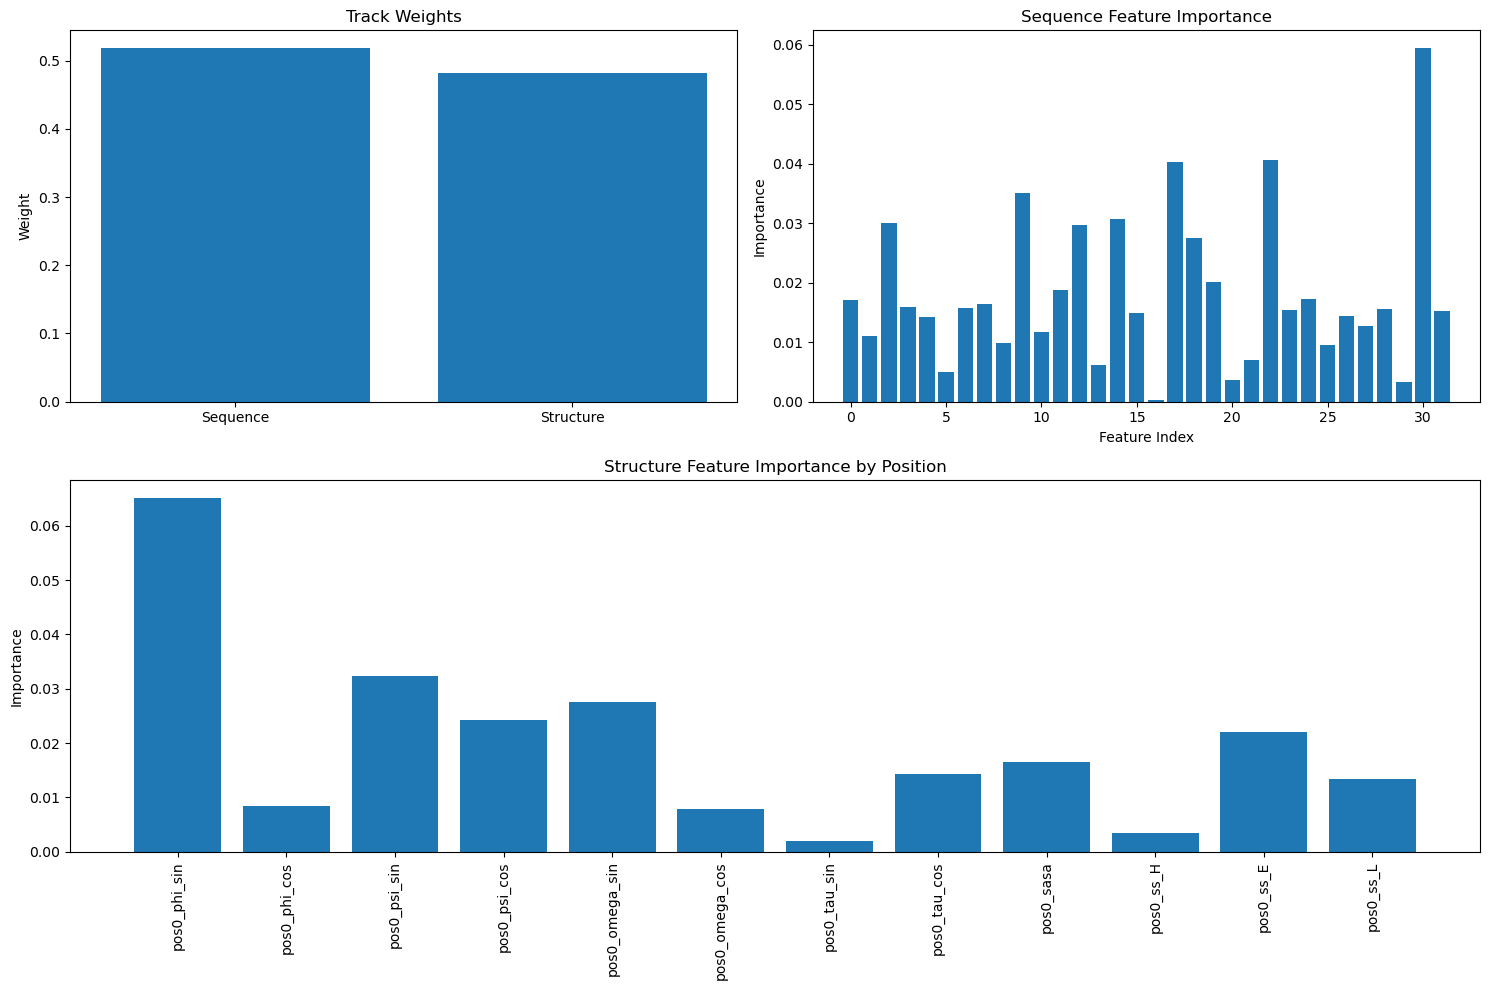


Fold 5 Results:
ACC: 0.5294
BALANCED_ACC: 0.5159
MCC: 0.0478
SN: 0.8899
SP: 0.1419

Track Weights:
Sequence: 0.5184
Structure: 0.4816
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


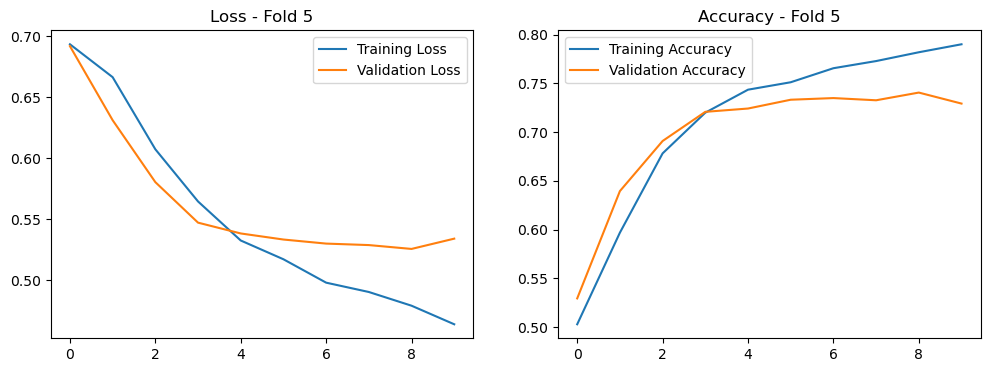


Final Cross-validation Results:
ACC: 0.6144 ± 0.1085
BALANCED_ACC: 0.6070 ± 0.1124
MCC: 0.2313 ± 0.2143
SN: 0.8177 ± 0.1360
SP: 0.3963 ± 0.2768

Average Track Weights Across Folds:
Sequence: 0.5416 ± 0.0404
Structure: 0.4584 ± 0.0404

Final Test Set Results:
Accuracy: 0.6847
Balanced Accuracy: 0.7425
MCC: 0.2841
Sensitivity: 0.8125
Specificity: 0.6724


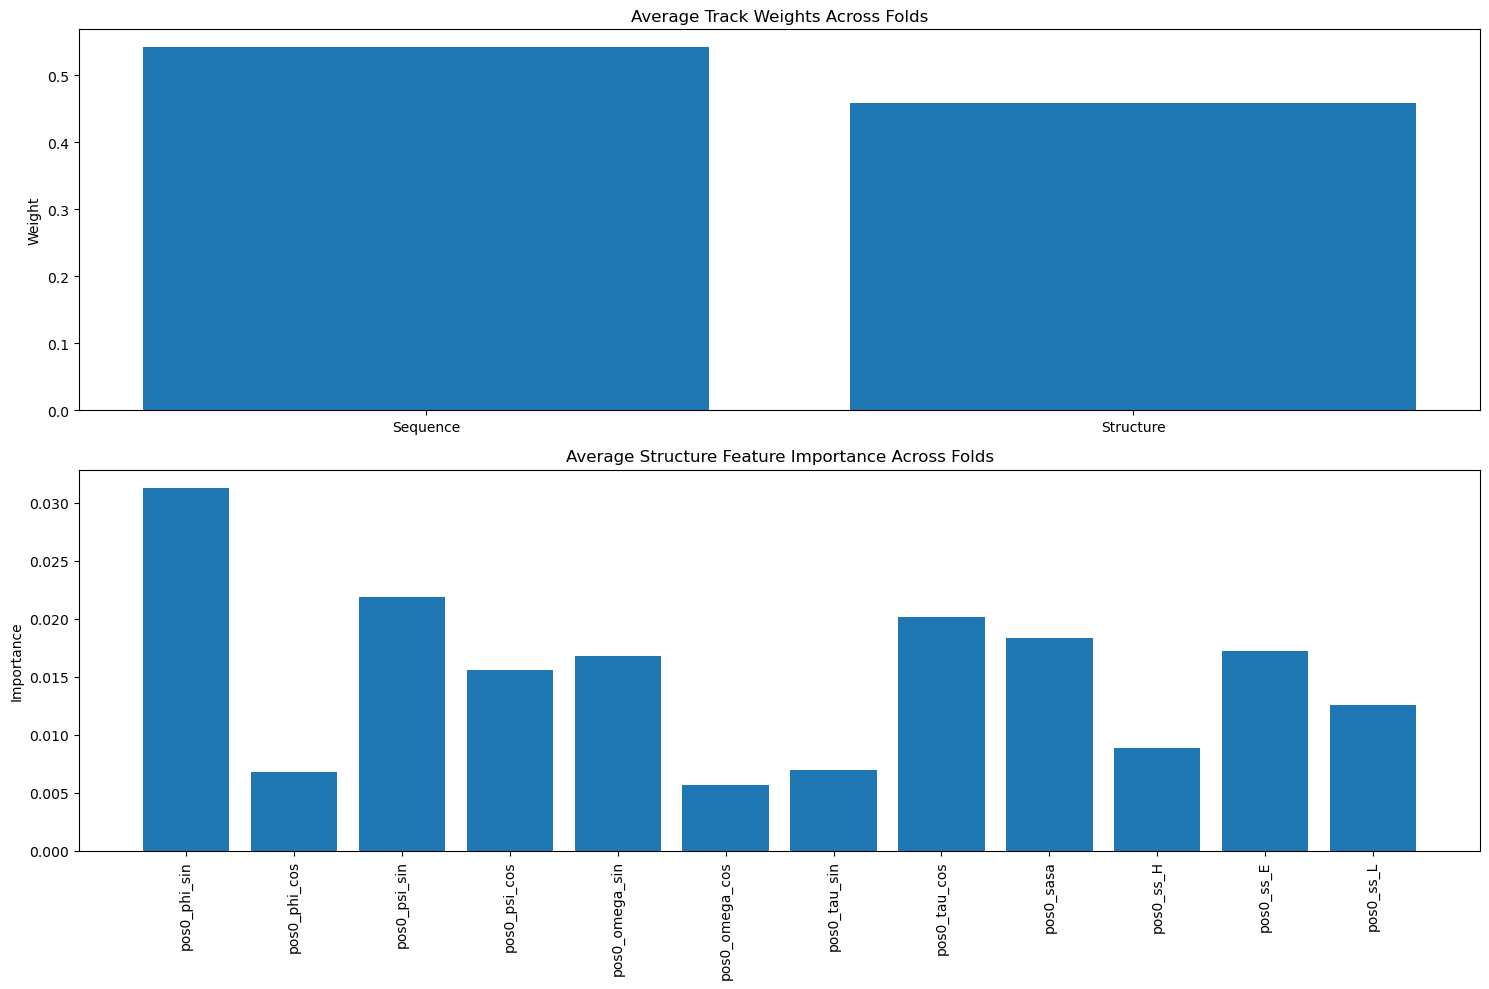

In [8]:
if __name__ == "__main__":
    # Set window size
    window_size = 0  # or any other size you want to try
    print(f"Training model with window size: {window_size}")
    print(f"This will consider {2*window_size + 1} positions centered on the target residue")
    
    # Train model
    model, attention_history = train_and_evaluate(struct_window=window_size)
    
    # Final analysis plots
    if attention_history:
        plt.figure(figsize=(15, 10))
        
        # Plot average track weights
        avg_seq_weight = np.mean([info['track_weights']['sequence'] for info in attention_history])
        avg_struct_weight = np.mean([info['track_weights']['structure'] for info in attention_history])
        
        plt.subplot(2, 1, 1)
        plt.bar(['Sequence', 'Structure'], [avg_seq_weight, avg_struct_weight])
        plt.title('Average Track Weights Across Folds')
        plt.ylabel('Weight')
        
        # Plot average structure feature importance
        struct_features = attention_history[0]['feature_weights']['structure']
        avg_struct_weights = {}
        for key in struct_features:
            avg_struct_weights[key] = np.mean([info['feature_weights']['structure'][key] 
                                             for info in attention_history])
        
        plt.subplot(2, 1, 2)
        plt.bar(range(len(avg_struct_weights)), list(avg_struct_weights.values()))
        plt.xticks(range(len(avg_struct_weights)), list(avg_struct_weights.keys()), rotation=90)
        plt.title('Average Structure Feature Importance Across Folds')
        plt.ylabel('Importance')
        
        plt.tight_layout()
        # plt.savefig('final_analysis.png')
        plt.show()